# GPTeal Image Pipeline

In [57]:
import os
from dotenv import load_dotenv
load_dotenv()

api_key = os.getenv('GPT_API_KEY')
if api_key is None:
  raise

headers = {
  "Content-Type": "application/json",
  "X-Merck-APIKey": api_key
}

## Use GPT to create image prompt

In [62]:
import requests
import json

GPT_URL = "https://iapi-test.merck.com/gpt/v2/gpt-35-turbo-0613/chat/completions?api-version=2023-08-01-preview"
img_call_convo = [
  {"role": "system", "content": """You are an image generation assistant, you do the following 3 things:
- based on the user high level description on a image requirement, helping users design the image prompt with the details such as drawing style, technique, composition, subject matter, mood and emotion, medium, detail and precision, artistic choices, historical or cultural context, personal interpretation.
- sends the designed image prompt back to the user for confirmation
- you should refine the prompt with the user before sending the prompt to the image generator"""},
]
img_call_question = "Hello! I see you're interested in creating an image. To help generate the perfect image for you, I'll need some details. Let's start with the basics"
img_prompt = ""

while img_prompt == "":
  user_msg = input(img_call_question)
  img_call_convo.append({"role": "user", "content": user_msg})
  payload = {
    "messages":img_call_convo,
    "functions": [{
      "name": "text_to_image_generator",
      "description": "A raster image generator function, a clear and detailed description of the image should be provided",
      "parameters": {
        "type": "object",
        "properties": {
          "prompt": {
            "type": "string",
            "description": "A text description of the desired image(s). The maximum length is 1000 characters"
          },
          "n": {
            "type": "number",
            "description": "Optional number of images to generate, default is 1",
            "enum": [1,2,3,4,5]
          },
          "size": {
            "type": "string",
            "description": "Optional size of the generated images the default is 1024x1024",
            "enum": ["256x256", "512x512", "1024x1024"]
          }
        },
        "required": ["prompt"]
      }
    }]
  }
  res = requests.post(GPT_URL, json=payload, headers=headers)
  output = res.json()
  if "status" in output and output["status"] != 200:
    print(output)
    raise
  choice = output['choices'][0]
  reason = choice['finish_reason']
  if reason == "function_call":
    arg_text = choice['message']['function_call']['arguments']
    args = json.loads(arg_text)
    img_prompt = args['prompt']
    print(img_prompt)
  else:
    img_call_question = choice['message']['content']
    print(img_call_question)
    img_call_convo.append({"role": "assistant", "content": img_call_question})


Sure! Could you please provide me with some more details about the realistic mermaid picture you would like to create? For example, could you describe the pose, the setting, the mood, or any specific characteristics or features you would like the mermaid to have? This will help me create a more accurate and satisfying prompt for the image generation.
Certainly! Here's a suggestion for a realistic mermaid picture:

Prompt: Create a realistic mermaid swimming gracefully in an underwater coral reef.

Description:
- The mermaid should have a slender and graceful body with long flowing hair. Her skin should have a beautiful iridescent shimmer, reflecting the colors of the underwater environment.
- The mermaid's tail should be a combination of vibrant colors, resembling the scales of tropical fish. You can use shades of blue, green, and purple to create a mesmerizing effect.
- The mermaid should be depicted swimming elegantly, with her arms gracefully extended and her tail curved in a flowin

## Generate image

{'result': 'success', 'artifacts': [{'seed': 10, 'base64': 'iVBORw0KGgoAAAANSUhEUgAAAgAAAAIACAIAAAB7GkOtAAAJoGVYSWZNTQAqAAAACAAGAQAABAAAAAEAAAIAAQEABAAAAAEAAAIAAQ4AAgAAA84AAABWARAAAgAAABQAAAQkATEAAgAAAA0AAAQ4khMAAQAABVoAAARGAAAAAENyZWF0ZSBhIHJlYWxpc3RpYyBtZXJtYWlkIHN3aW1taW5nIGdyYWNlZnVsbHkgaW4gYW4gdW5kZXJ3YXRlciBjb3JhbCByZWVmLgoKRGVzY3JpcHRpb246Ci0gVGhlIG1lcm1haWQgc2hvdWxkIGhhdmUgYSBzbGVuZGVyIGFuZCBncmFjZWZ1bCBib2R5IHdpdGggbG9uZyBmbG93aW5nIGhhaXIuIEhlciBza2luIHNob3VsZCBoYXZlIGEgYmVhdXRpZnVsIGlyaWRlc2NlbnQgc2hpbW1lciwgcmVmbGVjdGluZyB0aGUgY29sb3JzIG9mIHRoZSB1bmRlcndhdGVyIGVudmlyb25tZW50LgotIFRoZSBtZXJtYWlkJ3MgdGFpbCBzaG91bGQgYmUgYSBjb21iaW5hdGlvbiBvZiB2aWJyYW50IGNvbG9ycywgcmVzZW1ibGluZyB0aGUgc2NhbGVzIG9mIHRyb3BpY2FsIGZpc2guIFlvdSBjYW4gdXNlIHNoYWRlcyBvZiBibHVlLCBncmVlbiwgYW5kIHB1cnBsZSB0byBjcmVhdGUgYSBtZXNtZXJpemluZyBlZmZlY3QuCi0gVGhlIG1lcm1haWQgc2hvdWxkIGJlIGRlcGljdGVkIHN3aW1taW5nIGVsZWdhbnRseSwgd2l0aCBoZXIgYXJtcyBncmFjZWZ1bGx5IGV4dGVuZGVkIGFuZCBoZXIgdGFpbCBjdXJ2ZWQgaW4gYSBmbG93aW5nIG1h

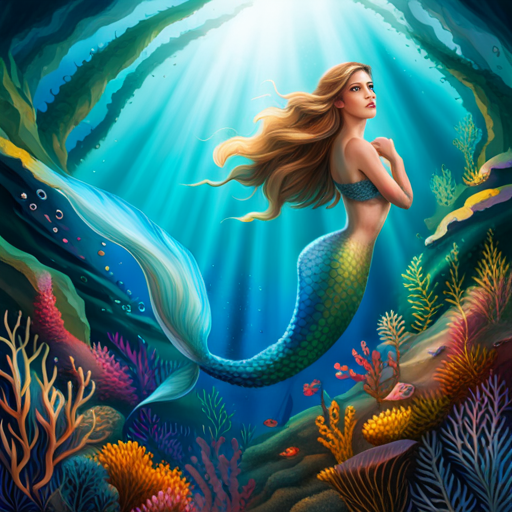

In [69]:
import requests
import io
import base64
from PIL import Image
from IPython import display

SD_URL = "https://iapi-test.merck.com/gpt/v2/stabilityai/stable-diffusion-xl"

payload = {
  'text_prompts':[{'text':img_prompt}],
  'cfg_scale':10,
  'seed':10,
  'steps':50
}
res = requests.post(SD_URL, json=payload, headers=headers)
output = res.json()
print(output)
decoded = base64.b64decode(output["artifacts"][0]["base64"])
image = Image.open(io.BytesIO(decoded))
display.display(image)


## Convert to Teal scale

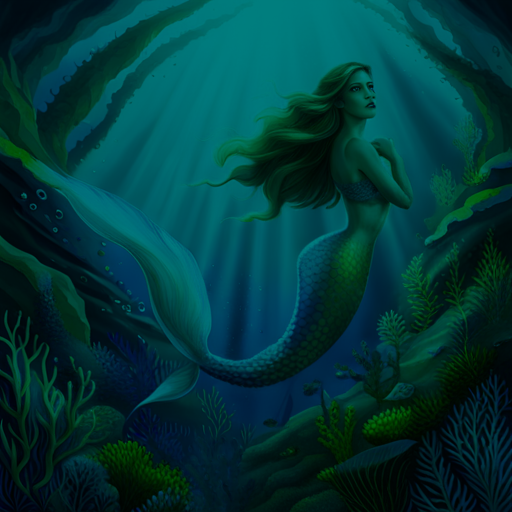

In [70]:
import numpy as np
from PIL import Image

def rgb2gray(img):
    grayImage = np.zeros(img.shape)
    R = np.array(img[:, :, 0])
    G = np.array(img[:, :, 1])
    B = np.array(img[:, :, 2])

    R = (R *.299)
    G = (G *.587)
    B = (B *.114)

    Avg = (R+G+B)
    grayImage = img.copy()

    for i in range(3):
        grayImage[:,:,i] = Avg
        
    return grayImage

def rgb2teal(img):

    tealImage = img.copy()
    
    R = 0
    G = np.array(img[:, :, 1])
    B = np.array(img[:, :, 2])

    G = (G *.5)
    B = (B *.5)

    Avg = (R+G+B)

    tealImage[:,:,0] = R
    tealImage[:,:,1] = G
    tealImage[:,:,2] = B
        
    return tealImage

image_np = np.array(image)
gray = rgb2teal(image_np)
im = Image.fromarray(gray, "RGB")
display.display(im)


## Add watermark

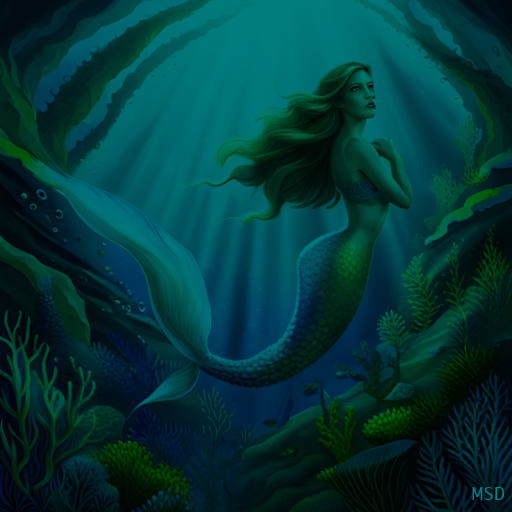

In [71]:
from PIL import Image, ImageDraw, ImageFont

watermark = Image.new('RGBA', im.size, (0,0,0,0))
draw = ImageDraw.Draw(watermark)
font = ImageFont.truetype("/System/Library/Fonts/Monaco.ttf", 18)
pos = (watermark.size[0] - 40, watermark.size[1] - 30)
color = (0, 128, 128)
draw.text(pos, "MSD", fill=color, font=font)

watermarked = Image.alpha_composite(im.convert('RGBA'), watermark)

display.display(watermarked)